<a href="https://colab.research.google.com/github/GitBar20/AI/blob/main/Test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Работа с операционной системой
import os

# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# класс для использования Functional API
from tensorflow.keras import Model

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты
from tensorflow.keras import utils

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
base_dir = "/content/drive/MyDrive/Build /Dset_build"

In [5]:
patch = 0
x_train = []
y_train = []
img_height = 2000
img_wight = 2000
for patch in os.listdir(base_dir):
  for img in os.listdir(base_dir + "/" + patch):
      x_train.append(image.img_to_array(image.load_img(base_dir + "/" + patch +"/"+ img,
                                                       target_size=(img_height,img_wight),
                                                       color_mode="grayscale")))
      y_train.append(0)

In [6]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print("размер x", x_train.shape)
print("размер y", y_train.shape)


размер x (31, 2000, 2000, 1)
размер y (31,)


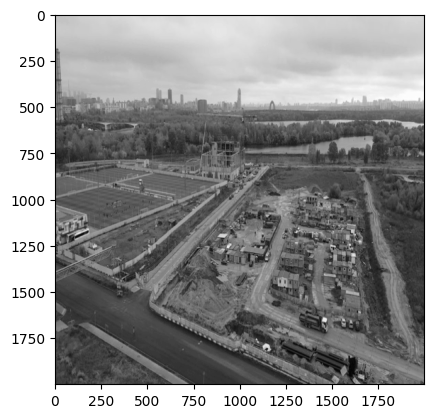

0


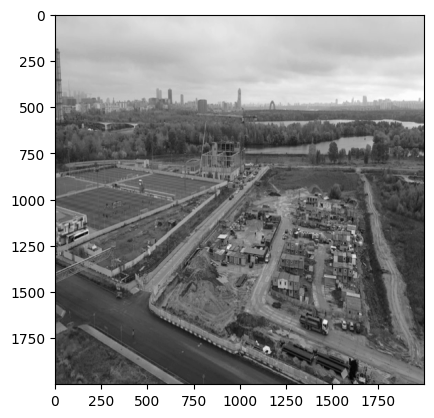

0


In [7]:
N_example = 1
plt.imshow(np.reshape(x_train[N_example],(2000, 2000)), cmap = "gray")
plt.show()
print(y_train[N_example])
N_example = 5
plt.imshow(np.reshape(x_train[N_example],(2000, 2000)), cmap = "gray")
plt.show()
print(y_train[N_example])